# pySPaRTAN: a Python computational framework for linking cell-surface receptors to transcriptional regulators

## Introduction

Cell identity and function are dependent on the complex signaling and transcriptional programs. Advances in single cell technology has enabled the transcriptional state analysis coupled with cell surface receptor expression. This tutorial will demo the usage of our computational framework SPaRTAN (Single-cell Proteomic and RAN-based Transcription factor Activity Network). SPaRTAN uses CITE-seq (Cellular Indexing of Transcriptomics and Epitopes by sequencing) data to link surface protein expression to inferred transcription factor activity. It models the flow of information from cell-surface receptors to transcription factors (TFs), and then regulate the target genes. More specifically, we use a regularized bilinear regression model to learn a cell-type specific interaction between cell surface protein and transcription factor activity that yields the best prediction of the target gene expression.

<img src="pySPaRTAN_diagram_1.png" alt="Diagram" width="600" />

## Environment setup

Suppose you have followed the instructions in README.txt and set up the Conda environment, installed JupyterLab, and the Python packages in requirements.txt.

First, we will install a few additional packages specific to this tutorial.
pySPaRTAN, a Python-based model, has optimized some computationally intensive Python functions by converting them into two platform-dependent Cython modules. 


Install Cython

In [ ]:
! pip install cython

Build two Cython objects. 

In [ ]:
! python  setup.py build_ext --inplace

After successfully building the Cython objects, there are two .so files generated on a Mac/Linux machine or .pyd files on a Windows machine.

In [ ]:
! ls 

Lastly, we will install the pySPaRTAN package.

In [ ]:
! pip install pySPaRTAN

We import the python packages used in this tutorial

In [2]:
import scanpy as sc
from muon import prot as pt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from itertools import chain
from adjustText import adjust_text

import pySPaRTAN

## Data pre-processing
### Data loading

We demonstrate the pipeline using the CITE-seq dataset of Peripheral Blood Mononuclear Cells (PBMC), which is freely available from 10X Genomics. 

We load the raw counts data saved in the .h5 file.

In [3]:
adata=sc.read_10x_h5("../data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
# making the variable name unique
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 5527 × 33570
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [4]:
set(adata.var["feature_types"])

{'Antibody Capture', 'Gene Expression'}

The ADT and RNA data are stored in the same adata object, differentiated by the feature_types variable. We will separate them into two distinct objects.

Extracting the ADT (protein) raw counts

In [5]:
ADT=adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()

# removing the isotype control for antibody
ADT=ADT[:,[x for x in ADT.var_names if "control" not in x]]

Extracting gene expression raw counts

In [6]:
RNA = adata[:, adata.var["feature_types"] == "Gene Expression"]

### Quality control

We calculate QC matrix and inspect some of the features:

* the number of genes expressed in the count matrix

* the total counts per cell

* the percentage of counts in mitochondrial genes

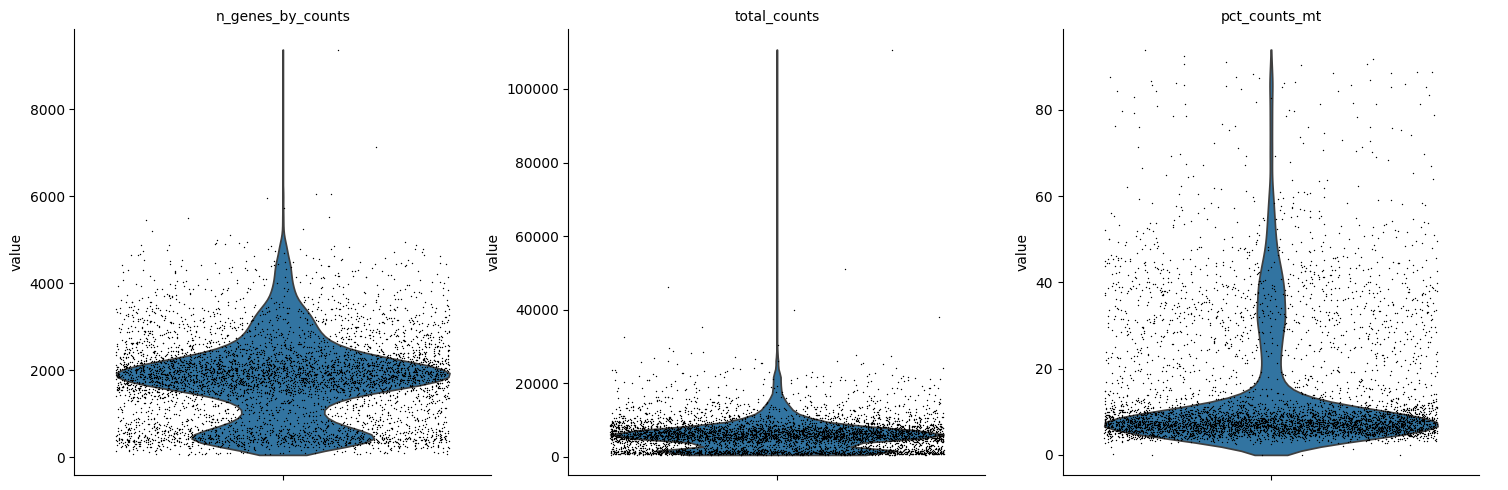

In [7]:
RNA.var['mt'] = RNA.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(RNA, qc_vars=['mt'], percent_top=None, log1p=False,inplace=True)

sc.pl.violin(
    RNA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Based on QC metric plots, we filter out cells with fewer than 1,000 or more than 5,500 unique gene sequences, as well as cells with more than 30% mitochondrial counts. Additionally, we exclude genes that are not present in at least 3% of cells. we also remove all mitoconondrial genes from the datset

In [8]:
sc.pp.filter_genes(RNA, min_cells=0.03*RNA.n_obs)
sc.pp.filter_cells(RNA, min_genes=1000)
RNA=RNA[RNA.obs.query("n_genes_by_counts < 5000 and pct_counts_mt<30").index]

# we also remove all mitoconondrial genes from the datset
RNA=RNA[:, RNA.var['mt']==False]

# Filter cells of ADT according to RNA
ADT = ADT[RNA.obs_names, :]

### Normalization

We scale the mRNA raw count data to a sum of 1e4 and normalize it with log1p transformation. 

In [9]:
sc.pp.normalize_total(RNA, target_sum=10000)
sc.pp.log1p(RNA)

For the protein, we normalize the raw counts using the center log ratio (CLR) transformation with the clr function from the Muon package.

In [10]:
pt.pp.clr(ADT)

## Cell type annotation

The pySPaRTAN model performs best when applied separately to data from different cell types. Next, we will prepare to annotate cell types.

Before further processing, we save the log-normalized mRNA data, which will be used as input for pySPaRTAN.

In [11]:
RNA.layers['log1p'] = RNA.X.copy()

### Feature selection
We subset features that only include highly variable genes which are highly expressed in some cells, and lowly expressed in others. Focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

We identify highly variable features and return top 5000 genes

In [12]:
sc.pp.highly_variable_genes(RNA, n_top_genes=5000)

### Dimensionality Reduction
Before reducing the dimensionality of the data, we apply a linear transformation that scales the data such that the mean expression across cells is 0 and the variance across cells is 1

In [13]:
sc.pp.scale(RNA)

We apply principal component analysis with default setting (return top 50 principal components)

In [14]:
sc.tl.pca(RNA)

To determine how many principal components we should choose to compute the neighborhood relations of the cells, we inspect the contribution of individual PCs to the total variance in the data

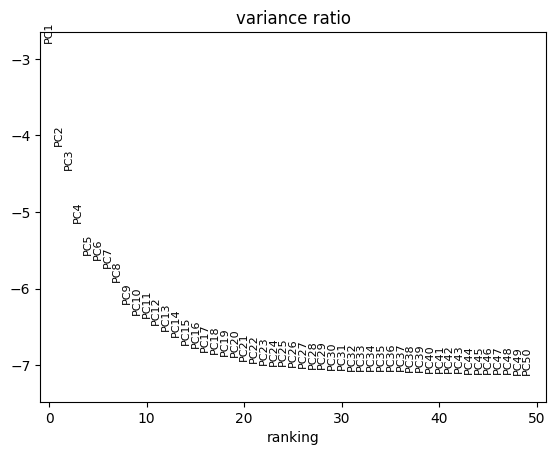

In [15]:
sc.pl.pca_variance_ratio(RNA, n_pcs=50, log=True)

From the elbow plot, we observe fist 20-30 principal components capture the majority of variance.

### Clustering

We use graph-based clustering approach using the PCA representation of the data. 

First Computing the nearest neighbors distance matrix and a neighborhood graph of observations 

In [16]:
sc.pp.neighbors(RNA)

Next cluster cells using  Leiden algorithm which is considered as an improved version of the Louvain algorithm

In [17]:
sc.tl.leiden(RNA, flavor="igraph", n_iterations=2)

The neighborhood graph can be embedded in two dimensions for visualization with UMAP.

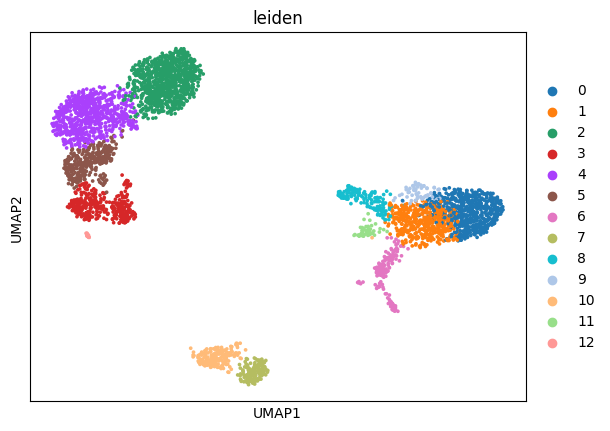

In [18]:
sc.tl.umap(RNA)
sc.pl.umap(RNA, color=["leiden"])

### Annotation

We annotated the cell types based on the below marker genes and proteins. 

In [19]:

display(HTML('<header class="u-mb-16"><h4 class="c-article-satellite-title u-h1" id="table-2-title">Marker genes used to assign cell types to clusters</h4></header><div class="c-article-table-container"><div class="c-article-table-border c-table-scroll-wrapper"><div class="c-table-scroll-wrapper__content" data-component-scroll-wrapper=""><table class="data last-table"><thead class="c-article-table-head"><tr><th class="u-text-left "><p>Cell type</p></th><th class="u-text-left "><p>Marker genes</p></th><th class="u-text-left "><p>Marker proteins</p></th></tr></thead><tbody><tr><td class="u-text-left "><p>CD8+</p></td><td class="u-text-left "><p><i>CD8A</i>, <i>CD8B</i>, <i>FCER1G</i></p></td><td class="u-text-left "><p>CD8a, CD4</p></td></tr><tr><td class="u-text-left "><p>Naive CD4+ T</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>CCR7</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RA, CD4</p></td></tr><tr><td class="u-text-left "><p>Memory CD4+</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>S100A4</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RO, CD4</p></td></tr><tr><td class="u-text-left "><p>NK</p></td><td class="u-text-left "><p><i>GNLY</i>, <i>NKG7</i></p></td><td class="u-text-left "><p>CD56</p></td></tr><tr><td class="u-text-left "><p>DC</p></td><td class="u-text-left "><p><i>FCER1A</i>, <i>CST3</i></p></td><td class="u-text-left "> </td></tr><tr><td class="u-text-left "><p>CD14+ Mono</p></td><td class="u-text-left "><p><i>CD14</i>, <i>LYZ</i></p></td><td class="u-text-left "><p>CD14</p></td></tr><tr><td class="u-text-left "><p>FCGR3A+/CD16+ Mono</p></td><td class="u-text-left "><p><i>FCGR3A</i>, <i>MS4A7</i></p></td><td class="u-text-left "><p>CD16</p></td></tr><tr><td class="u-text-left "><p>B</p></td><td class="u-text-left "><p><i>MS4A1</i></p></td><td class="u-text-left "><p>CD20, CD19</p></td></tr></tbody></table></div></div></div><div class="u-text-right"></div>'))


Cell type,Marker genes,Marker proteins
CD8+,"CD8A, CD8B, FCER1G","CD8a, CD4"
Naive CD4+ T,"IL7R, CCR7, CD3E","CD45RA, CD4"
Memory CD4+,"IL7R, S100A4, CD3E","CD45RO, CD4"
NK,"GNLY, NKG7",CD56
DC,"FCER1A, CST3",
CD14+ Mono,"CD14, LYZ",CD14
FCGR3A+/CD16+ Mono,"FCGR3A, MS4A7",CD16
B,MS4A1,"CD20, CD19"


The process involved multiple iteration of subclustering and re-annotation, it's difficult to show the entire process. We load the saved cell_type annotation file. 

In [20]:
df_ct = pd.read_csv("../data/cell_types_PBMC.csv", index_col=0)

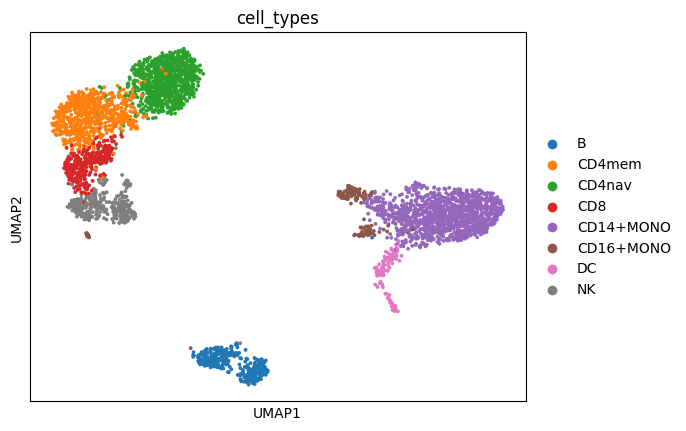

In [21]:
# Annotating cell type on UMAP
RNA=RNA[np.intersect1d(RNA.obs_names, df_ct.index)] 
RNA.obs["cell_types"] = df_ct.loc[RNA.obs_names]
sc.pl.umap(RNA, color=["cell_types"])

Checking number of cells for cell type.

In [22]:
RNA.obs["cell_types"].value_counts()

cell_types
CD14+MONO    1201
CD4nav        907
CD4mem        702
NK            352
B             332
CD8           318
CD16+MONO     139
DC             99
Name: count, dtype: int64

## Reviewing pySPaRTAN model

 we use a regularized bilinear regression algorithm called affinity regression (AR) to learn a cell-type specific interaction matrix between cell-surface proteins and TFs that predicts target gene expression. 
 
<img src="pySPaRTAN_diagram_2.png" alt="Diagram" width="600" />


There are three inputs for the package: D, P Y

D: gene-tf matrix.

P: cell x ADT matrix. 

Y: gene x cell matrix, 

we set up a bilinear regression problem to learn the weight (interaction) matrix W  between TFs and cell surface proteins that predicts TF-target gene expression by

<img src="equation_1.png" alt="Diagram" width="120" />

We solve for W by the convex optimization problem with L1 and L2 norm regularizers as:

<img src="equation_4.png" alt="Diagram" width="400" />

After training the model, we obtain the learned TF and protein interaction matrix W. From matrix W we can 
1. predict TF activities from the cell surface protein expression profile
   

2. protein activities from the cellular mRNA expression data and the TF-target gene matrix



<img src="pySPaRTAN_diagram_3.png" alt="Diagram" width="600" />

## Generating pySPaRTAN input data

Loading gene-TF matrix

In [23]:
# pySPaRTAN model contains the curated gene-TF matrix for PBMC dataset
geneTF = pySPaRTAN.datasets.load_dorthea()
geneTF.shape

(2643, 255)

Note: SPaRTAN model requires log normalized RNA expression as input. Current RNA.X has been scaled during cell type annotation, we need to load the normalized data back to RNA.X

In [24]:
RNA.X = RNA.layers['log1p']
# Aligning the genes in RNA with those in geneTF matrix
RNA = RNA[:, geneTF.index]

As we mentioned previously, tshe pySPaRTAN model performs best when applied separately to data from different cell types. We will extract RNA and ADT data for each cell type.

In [25]:
RNAs={}; ADTs={}
for celltype in set(df_ct["cell_types"]):
    index_type = df_ct.index[df_ct["cell_types"]==celltype]
    RNA_type = RNA[RNA.obs_names.isin(index_type)].to_df()
    ADT_type = ADT[ADT.obs_names.isin(index_type)].to_df()

    RNAs[celltype] = RNA_type
    ADTs[celltype] = ADT_type

RNAs.keys()

dict_keys(['DC', 'CD14+MONO', 'CD16+MONO', 'NK', 'B', 'CD8', 'CD4mem', 'CD4nav'])

In [26]:
RNAs['CD8']

,NOC2L,ISG15,TNFRSF18,ACAP3,DVL1,AURKAIP1,MRPL20,MIB2,CDK11A,NADK,...,TRAPPC10,PFKL,TRPM2,SUMO3,PTTG1IP,ITGB2,ADARB1,COL18A1,SLC19A1,S100B
AACACACCAATCCTAG-1,1.553033,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.553033,0.000000,0.0,1.553033,0.0,1.553033,0.000000,0.0,0.000000,0.000000
AACAGGGAGCGAAACC-1,0.889916,0.000000,0.0,0.0,0.0,0.000000,1.353216,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.889916,0.0,1.353216,0.000000,0.0,0.889916,0.000000
AACCAACTCGAGTACT-1,1.128693,0.000000,0.0,0.0,0.0,1.128693,0.000000,1.645427,1.128693,0.000000,...,0.000000,0.000000,0.0,1.128693,0.0,1.128693,0.000000,0.0,0.000000,2.875422
AACCATGCAATGCAAA-1,0.000000,0.000000,0.0,0.0,0.0,1.068981,1.068981,0.000000,0.000000,0.000000,...,0.000000,1.068981,0.0,1.068981,0.0,1.573774,0.000000,0.0,0.000000,0.000000
AACGGGAGTGAGATAT-1,1.605132,1.941296,0.0,0.0,0.0,1.095025,0.000000,1.095025,0.000000,0.000000,...,0.000000,1.095025,0.0,0.000000,0.0,1.941296,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTAATGCTC-1,0.000000,2.730933,0.0,0.0,0.0,0.953253,0.000000,0.953253,0.000000,0.000000,...,0.953253,0.000000,0.0,0.000000,0.0,0.953253,0.000000,0.0,0.000000,0.000000
TTGTTGTGTACCTTCC-1,0.000000,2.000282,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.141154,...,0.000000,1.141154,0.0,0.000000,0.0,2.767115,1.141154,0.0,0.000000,0.000000
TTGTTTGTCGACCCAG-1,0.000000,1.149485,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.149485,0.0,1.149485,0.000000,0.0,0.000000,0.000000
TTTAGTCTCGGTGCAC-1,0.000000,1.399680,0.0,0.0,0.0,0.000000,1.399680,0.927013,1.399680,0.000000,...,0.000000,0.927013,0.0,0.927013,0.0,1.961193,0.000000,0.0,0.000000,0.000000


## Training cell-type specific pySPaRTAN model
After preparing the input for pySPaRTAN, we are ready to run the model. We will use the CD8 T cell to demonstrate the procedure.

In [27]:
ct = "CD8"
D = geneTF.copy()
P = ADTs[ct].copy()
Y = RNAs[ct].copy()

In [28]:
D.shape, P.shape, Y.shape

((2643, 255), (318, 29), (318, 2643))

P and Y are normalized CD8 T cell protein and RNA expression where each row represent a cell and each column represent a protein or a gene.  Different cell type will have different dimension size of P and Y matrix. While gene-TF matrix has the fixed size for all cell types. 

Note: The P matrix is corresponding to the Pt in above diagram figure

We train the model using 80% of all cells in the dataset. The remaining 20% will be reserved for testing to evaluate the model’s performance.

In [29]:
P_train, P_test, Y_train, Y_test = train_test_split(
    P, Y, test_size=0.2, random_state=0)

pySPaRTAN is a bilinear model that incorporates three hyperparameters: lambda, alpha, and spectrum. Lambda and alpha control the trade-off between L1 and L2 regularization. Spectrum controls the truncation of the P matrix through singular value decomposition. For example, setting spectrum=0.7 specifies the number of singular vectors capturing 70% of the full spectrum

For optimization, we employ cross-validation and grid search to determine the optimal values of lambda (ranging from 1e-5 to 10) and alpha (ranging from 0 to 1). The spectrum parameter requires less tuning; hence, we fix it at 0.7.

Upon initializing the model, we define the ranges for lambda and alpha as follows:

In [30]:
model= pySPaRTAN.SPaRTAN(lamda=[0.0001,10],
                                 alpha=[0,1],
                                 spectrum=0.7)


Training the model by calling the fit function

In [31]:
model.fit(Y=Y_train,P=P_train, D=D)

After training the model on the training dataset, we evaluate its ability to predict gene expression based on protein expression using the testing dataset

In [32]:
model.score(P=P_test.values, Y=Y_test.values)

0.7023464158412044

This score is the correlation between predicted gene expression and observed gene expression, serving as the evaluation metric for prediction performance.

Now, we obtain the inferred TF activity for all cells of a given cell type based on the protein expression of that cell type.

In [33]:
tf =model.get_projD(P)
tf

,CREB1,JUN,TEAD1,FOS,RXRA,PBX3,MYC,RARA,PPARG,PAX6,...,SMARCC1,KMT2B,FOXO4,SSRP1,SMAD5,ZNF274,UBTF,ZNF592,TGIF2,GATAD1
AACACACCAATCCTAG-1,1.226361,-0.163664,-0.670014,0.015026,-0.471998,0.884206,1.355014,0.877198,1.690990,-0.091061,...,0.765587,-0.466734,-0.190677,2.737801,0.147348,1.356031,0.733885,-0.488133,-0.283065,0.550071
AACAGGGAGCGAAACC-1,1.991805,0.148528,-0.913437,0.162453,-0.574748,1.198612,2.303430,1.214031,2.157314,0.145044,...,1.001870,-0.744030,-0.123914,4.363729,0.339086,2.094692,1.078873,-0.764986,-0.282963,0.768434
AACCAACTCGAGTACT-1,0.921437,0.120515,-0.422491,0.302310,-0.223244,0.635846,1.713624,0.680347,1.183163,0.177777,...,0.604202,-0.376930,-0.177448,3.030819,0.199401,1.093366,0.420581,-0.328630,-0.155928,0.356432
AACCATGCAATGCAAA-1,2.093163,0.069773,-0.888198,0.004651,-0.618253,1.342721,1.626464,1.162341,2.182962,-0.102876,...,0.993285,-0.707374,-0.017972,4.155505,0.450262,2.241299,1.137893,-0.602639,-0.203458,0.886350
AACGGGAGTGAGATAT-1,2.133834,0.019416,-0.987733,0.003853,-0.677158,1.254810,2.054408,1.195789,2.190671,-0.054250,...,1.003790,-0.736735,-0.094772,4.304406,0.405194,2.240302,1.133285,-0.691071,-0.233375,0.833457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTAATGCTC-1,2.529814,0.233635,-1.043974,-0.035958,-0.679952,1.441115,2.103322,1.374179,2.341727,-0.052637,...,1.069733,-0.809570,0.007966,4.888663,0.552513,2.567840,1.221835,-0.685793,-0.215270,0.964847
TTGTTGTGTACCTTCC-1,1.728366,-0.106522,-0.969624,0.055146,-0.628844,1.173421,1.979724,1.141196,2.399641,0.074648,...,1.131860,-0.672004,-0.376099,4.079179,0.219451,1.813508,0.975683,-0.738858,-0.447160,0.649783
TTGTTTGTCGACCCAG-1,1.318068,0.166507,-0.682558,0.231445,-0.349419,0.892766,2.038403,0.939890,1.702480,0.089763,...,0.866721,-0.491398,-0.186204,4.301730,0.399993,1.632351,0.580881,-0.385999,-0.199195,0.536540
TTTAGTCTCGGTGCAC-1,1.763710,-0.219326,-0.824708,0.233157,-0.587222,1.338690,1.738504,1.056635,2.217677,0.146142,...,1.030380,-0.703360,-0.189783,3.861160,0.251800,1.874373,1.086727,-0.721473,-0.345876,0.750620


## Analyzing results

Here we explore the associations between inferred TF activity and surface protein expression at a single-cell level.

We first compute Pearson correlation coefficients between inferred TF activity and surface protein expression for each TF-protein pair within the cell-type

In [34]:
tf_protein = model.get_tf_protein_cor()
tf_protein

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD11b_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB,CD16_TotalSeqB,CD19_TotalSeqB,CD20_TotalSeqB,CD25_TotalSeqB,...,CD86_TotalSeqB,CD127_TotalSeqB,CD137_TotalSeqB,CD197_TotalSeqB,CD274_TotalSeqB,CD278_TotalSeqB,CD335_TotalSeqB,PD-1_TotalSeqB,HLA-DR_TotalSeqB,TIGIT_TotalSeqB
CREB1,0.064895,-0.398363,0.750936,-0.267911,0.206237,0.039656,0.023227,0.143656,0.518023,0.208653,...,0.165478,0.182999,0.280904,0.184618,0.037593,0.292781,0.027263,0.297852,0.221254,0.470796
JUN,0.239648,0.480688,-0.600230,-0.094804,0.078916,0.177424,-0.140679,0.054074,0.185402,0.180245,...,-0.153512,0.746851,-0.113203,0.097686,0.174758,0.036923,-0.023846,0.162818,-0.262834,-0.405657
TEAD1,-0.069189,0.435782,-0.779457,0.098495,-0.214408,-0.097729,-0.102913,-0.172783,-0.404021,-0.195859,...,-0.194720,-0.065805,-0.265786,-0.243930,-0.101737,-0.231817,-0.143426,-0.300341,-0.246019,-0.559046
FOS,0.259003,0.533920,-0.491080,0.153537,-0.075949,0.050570,0.007352,0.093011,-0.307322,-0.034748,...,-0.122398,-0.050003,-0.118390,-0.146166,0.088665,0.258768,-0.026654,0.005022,-0.123172,-0.325492
RXRA,0.036335,0.429888,-0.806092,0.172791,-0.158274,-0.010743,-0.025725,-0.121477,-0.361604,-0.128951,...,-0.179449,0.032496,-0.311183,-0.178782,-0.008182,-0.248329,-0.079386,-0.320190,-0.249883,-0.617333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF274,0.140924,-0.178041,0.579864,-0.287513,0.220360,0.119930,-0.010503,0.174675,0.469944,0.186084,...,0.187521,0.312864,0.337332,0.246341,0.076354,0.430431,0.020548,0.485472,0.249906,0.435011
UBTF,-0.054910,-0.291289,0.797850,-0.259097,0.160625,-0.007637,0.011003,0.154543,0.397190,0.113062,...,0.181464,0.066120,0.270526,0.160056,0.032984,0.412018,0.005669,0.392966,0.232214,0.574333
ZNF592,-0.025142,0.631880,-0.945158,0.042047,-0.141670,0.041177,-0.103894,-0.093142,-0.268449,-0.098010,...,-0.138854,0.200272,-0.125697,-0.114386,0.012152,-0.128219,-0.104586,0.099147,-0.198287,-0.526340
TGIF2,-0.120923,0.352396,-0.590506,-0.105897,-0.092838,-0.093014,-0.233868,-0.157895,-0.022179,-0.017638,...,-0.105237,0.488876,-0.030457,-0.026436,-0.152981,-0.072820,-0.307274,0.133239,-0.148081,-0.618660


Trim the end of protein names

In [35]:
tf_protein.columns = tf_protein.columns.str[:-10]
tf_protein.columns

Index(['CD3', 'CD4', 'CD8a', 'CD11b', 'CD14', 'CD15', 'CD16', 'CD19', 'CD20',
       'CD25', 'CD27', 'CD28', 'CD34', 'CD45RA', 'CD45RO', 'CD56', 'CD62L',
       'CD69', 'CD80', 'CD86', 'CD127', 'CD137', 'CD197', 'CD274', 'CD278',
       'CD335', 'PD-1', 'HLA-DR', 'TIGIT'],
      dtype='object')

We filter out the TF and protein with lower absolute correlation values 

In [36]:
proteins_to_plot = tf_protein.columns[abs(tf_protein).max(axis=0) > 0.7]
tfs_to_plot = tf_protein.index[abs(tf_protein).max(axis=1) > 0.8]
tf_protein_plot = tf_protein.loc[tfs_to_plot, proteins_to_plot]

Then we plot heatmap of the selected protein-TF correlation

Text(0.5, 1.05, 'CD8 T cell protein-TF correlation')

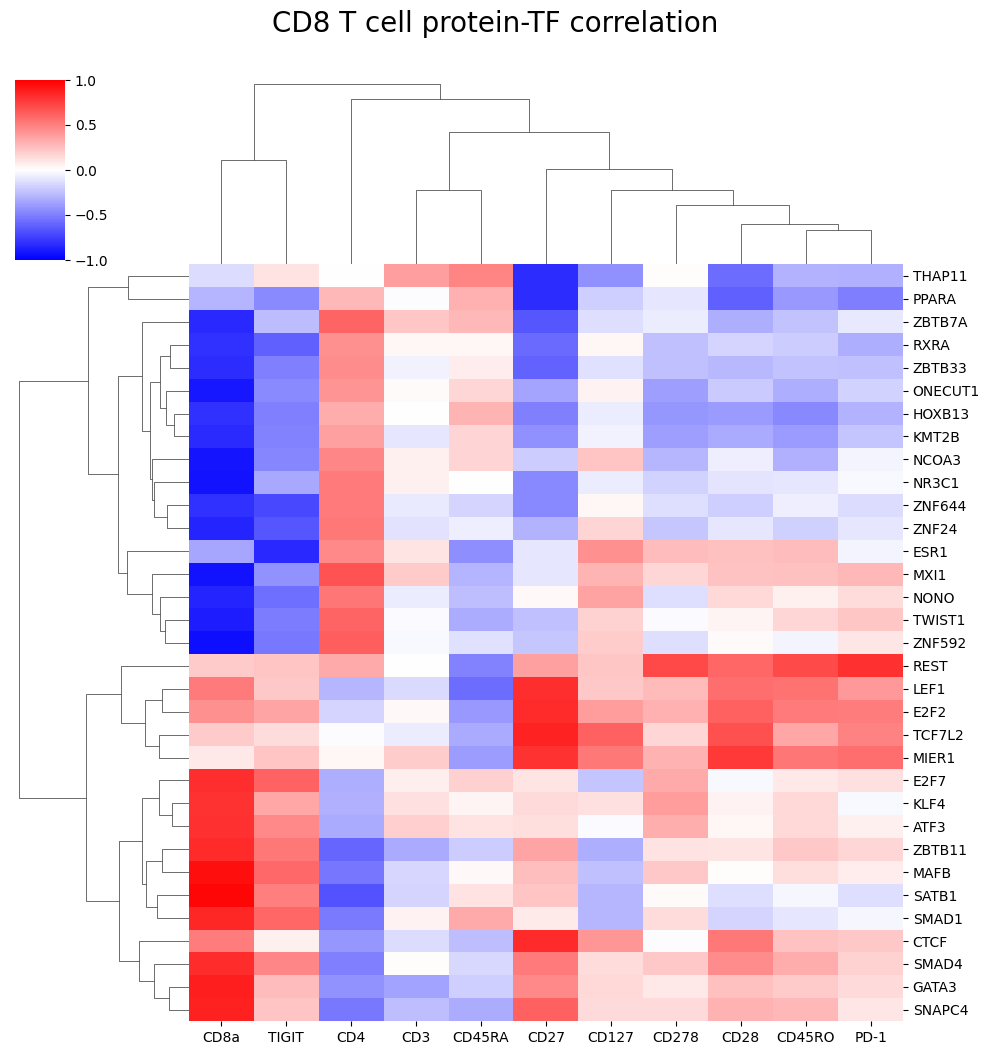

In [37]:
sns.clustermap(
    tf_protein_plot,
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle(ct + " T cell protein-TF correlation", y=1.05,fontsize=20)

Finally, we plot the TF correlation with specific protein, highlight the TFs with highest and lowest correlations.

Defining the plot function

In [38]:
def line_plot(pcc,prot, N, ax):
    
    pcc_prot = pcc.loc[:, prot].sort_values()

    labels = pcc_prot

    x= range(1,len(pcc_prot)+1)
    y=pcc_prot
    l=pcc_prot.index
    ax.scatter(x, y, s=8)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    texts = [ax.text(x[i], y[i], '%s' %l[i], ha='center', va='center', fontsize=10) for i in range_c]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r'), ax=ax, min_arrow_len=0, time_lim=0.1)

    ax.set_xlabel("TF ranking", fontsize=15)
    ax.set_ylabel(f"Corr between {prot} exp and TF activity", fontsize=15)
    ax.set_title(prot)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    TF_labels = [l[i] for i in range_c]
    return(TF_labels)


Plotting lineplot

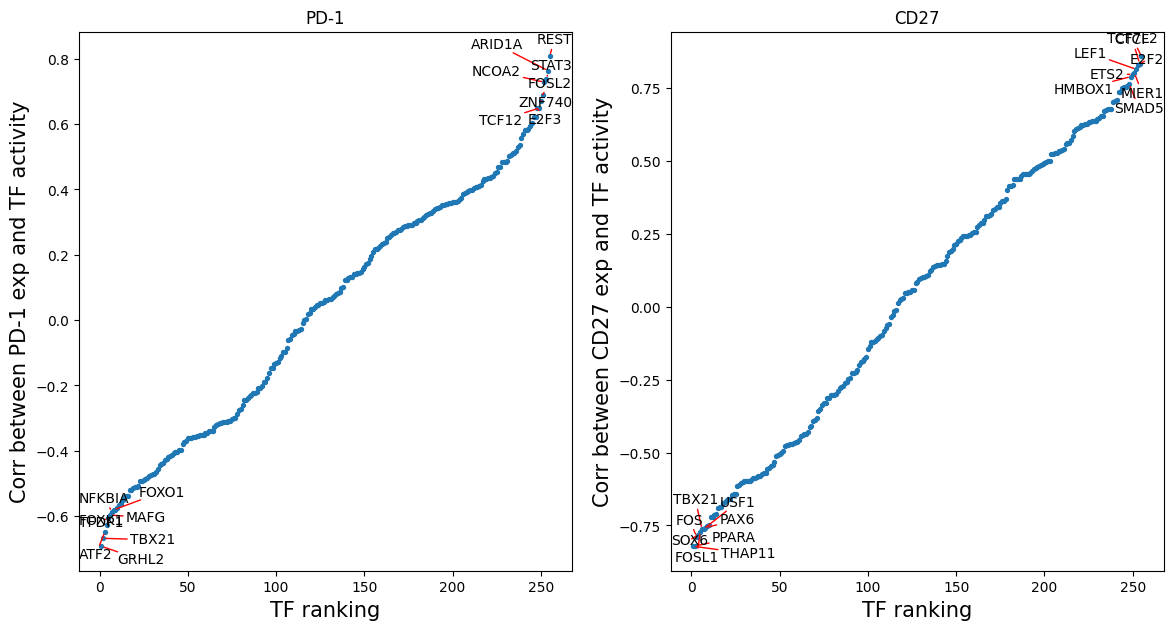

In [39]:
plt.rcParams['figure.figsize'] = [14, 7]
fig, ax = plt.subplots(1,2)
prot = "PD-1"
line_plot(tf_protein, prot, 8, ax[0])
prot = "CD27"
line_plot(tf_protein, prot, 8, ax[1])

fig.show()
